In [2]:
import pandas as pd
import numpy  as np

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn import tree, svm, neighbors
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge

### Первичный анализ датасета

**Предметная область** - доход и размеры домашних хозяйств Калифорнии по данным до 1990г.
Признаки в таблице:
1) Median House Value: Медианная цена дома в квартале[$]
2) Median Income: Медианный доход на семью в квартале[10тыс.$] (TARGET)
3) Median Age: Медианный возраст дома в квартале; меньше = новее [лет]
4) Total Rooms: Общее количество комнат в квартале
5) Total Bedrooms: Общее количество спален в квартале
6) Population: Общее количество людей, проживающих в квартале
7) Households: Общее количество домохозяйств, групп людей, проживающих в жилом помещении, в квартале
8) Latitude: показатель того, насколько далеко на север находится дом; чем выше значение, тем дальше на север [°]
9) Longitude: показатель того, насколько далеко на запад находится дом; чем выше значение, тем дальше на запад [°]
10) Distance to coast: расстояние до ближайшей точки побережья [м]
11) Distance to Los Angeles: расстояние до центра Лос-Анджелеса [м]
12) Distance to San Diego: расстояние до центра Сан-Диего [м]
13) Distance to San Jose: расстояние до центра Сан-Хосе [м]
14) Distance to San Francisco: расстояние до центра Сан-Франциско [м]
15) Distance to the ocean (Расстояние до океана)

Структура csv-файла:
- Ячейки разделены ";"
- Дробная часть помечена "."
- Нечисловой признак - ocean_proximity
- Дат не представлено
- Null помечены "?$?" (единственная запись)

In [3]:
dataset_file = "datasets/dataset_prepared.csv"
df = pd.read_csv(
    dataset_file,
    sep=';',
    decimal='.',
    header=0,
    na_values=['?$?']
)

df.head()

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco,OcPrx_<1H OCEAN,OcPrx_INLAND,OcPrx_ISLAND,OcPrx_NEAR BAY,OcPrx_NEAR OCEAN
0,352100,7.2574,52,1467.0,190,496,177,37.85,-122.24,8259.085109,554610.7171,733525.6829,64867.28983,18811.48745,0,0,0,1,0
1,342200,3.8462,52,1627.0,280,565,259,37.85,-122.25,7768.086571,555194.2661,734095.2907,65287.13841,18031.04757,0,0,0,1,0
2,269700,4.0368,52,919.0,213,413,193,37.85,-122.25,7768.086571,555194.2661,734095.2907,65287.13841,18031.04757,0,0,0,1,0
3,299200,3.6591,52,2535.0,489,1094,514,37.84,-122.25,6843.020847,554364.4069,733249.8086,64315.99174,17538.20997,0,0,0,1,0
4,241400,3.1200,52,3104.0,687,1157,647,37.84,-122.25,6843.020847,554364.4069,733249.8086,64315.99174,17538.20997,0,0,0,1,0


Выясним размеры датасета

In [4]:
num_rows, num_cols = df.shape
print(f"Размеры набора данных: {num_rows} строк и {num_cols} столбцов\n")
df.info()

Размеры набора данных: 16361 строк и 19 столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16361 entries, 0 to 16360
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Median_House_Value        16361 non-null  int64  
 1   Median_Income             16361 non-null  float64
 2   Median_Age                16361 non-null  int64  
 3   Tot_Rooms                 16361 non-null  float64
 4   Tot_Bedrooms              16361 non-null  int64  
 5   Population                16361 non-null  int64  
 6   Households                16361 non-null  int64  
 7   Latitude                  16361 non-null  float64
 8   Longitude                 16361 non-null  float64
 9   Distance_to_coast         16361 non-null  float64
 10  Distance_to_LA            16361 non-null  float64
 11  Distance_to_SanDiego      16361 non-null  float64
 12  Distance_to_SanJose       16361 non-null  float64
 13  Distance_to

---

### Выбор целевого значения и признаков для анализа данных

Целевой признак - Median Income: Медианный доход на семью в квартале[10тыс.$].

Построим матрицу корреляции (коэфф. корреляции Пирсона) для возможных комбинай пар.

In [5]:
target=['Median_Income']
corr_coeffs = df.corr(method='pearson')
corr_coeffs.style.background_gradient(cmap='coolwarm', axis=None)
corr_coeffs[target[0]].abs().sort_values(ascending=False)

Median_Income               1.000000
Median_House_Value          0.603495
Tot_Rooms                   0.237004
Median_Age                  0.184637
OcPrx_INLAND                0.156272
Distance_to_coast           0.155083
OcPrx_<1H OCEAN             0.136902
Tot_Bedrooms                0.079887
Distance_to_SanJose         0.066688
Population                  0.060554
Distance_to_SanFrancisco    0.050521
Households                  0.046777
Longitude                   0.033349
OcPrx_NEAR BAY              0.026521
OcPrx_NEAR OCEAN            0.026242
Latitude                    0.019742
Distance_to_LA              0.011811
OcPrx_ISLAND                0.011041
Distance_to_SanDiego        0.006869
Name: Median_Income, dtype: float64

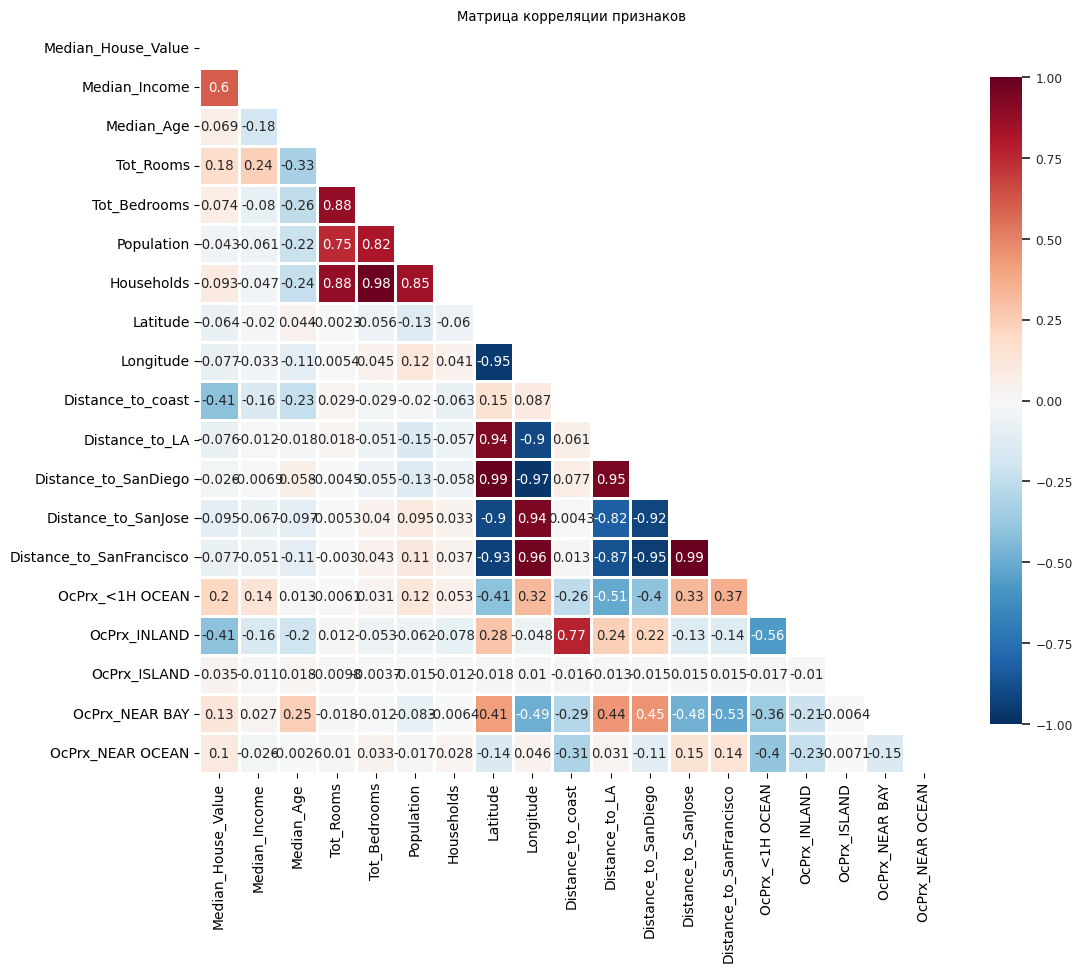

In [6]:
mask = np.zeros_like(corr_coeffs, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12,12))
sns.set_theme(font_scale=0.8)

sns.heatmap(
            data=corr_coeffs,
            vmin=-1, vmax=1, center=0,
            annot=True,
            cmap = 'RdBu_r',
            mask=mask,
            square=True,
            linewidths=1.0,
            cbar_kws={"shrink": .7}
           )
plt.title(u'Матрица корреляции признаков');

В качестве независимых переменных выберем признаки с высоким абс. значением коэфф. корреляции, но при этом как можно более не связанные между собой. Кандидаты:
- *Median_House_Value* - Медианная цена дома в квартале [$]
- *Distance_to_coast*- расстояние до ближайшей точки побережья [м] (или *OcPrx_INLAND*)
- *Tot_Rooms* - Общее количество комнат в квартале
- *Median_Age* - Медианный возраст дома в квартале; меньше = новее [лет]

In [7]:
features = ['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms',  'Median_Age', 'Population']

Получим следующие распределения значений

Median_House_Value 14999 479700
Distance_to_coast 120.6764466 119986.2118
Tot_Rooms 6.0 5998.0
Median_Age 1 52
Population 3 8733
Median_Income 0.4999 8.0


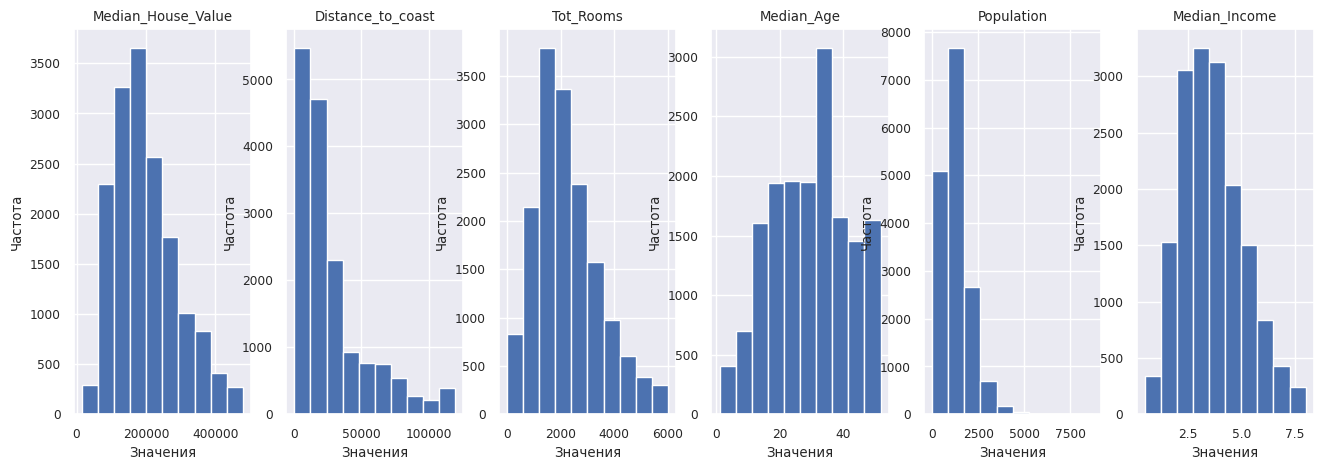

In [8]:
# dataset_filtered[features].hist() #Упрощенный вывод графиков

plt.figure(figsize=(16, 5))
plot_number = 0

for feature_name in (features+target):
    plot_number += 1
    plt.subplot(1, len(features+target), plot_number)
    plt.hist(df[feature_name])

    plt.title(feature_name)
    plt.xlabel(u'Значения')
    plt.ylabel(u'Частота')
    print (feature_name,
           df[feature_name].min(),
           df[feature_name].max())

Уберем все прочие признаки

In [9]:
df = df[target +features]
df.head()

,Median_Income,Median_House_Value,Distance_to_coast,Tot_Rooms,Median_Age,Population
0,7.2574,352100,8259.085109,1467.0,52,496
1,3.8462,342200,7768.086571,1627.0,52,565
2,4.0368,269700,7768.086571,919.0,52,413
3,3.6591,299200,6843.020847,2535.0,52,1094
4,3.1200,241400,6843.020847,3104.0,52,1157


### Объявление функций

In [10]:
def plot_difference(y_test, y_pred) -> None:
    '''
    Функция построения графиков
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    plt.scatter(y_test, y_pred,  alpha=0.1, color = "#17becf")
    plt.axline((0, 0), slope=1, color='black', linestyle='--', linewidth=3, alpha=0.7,)
    range_test, range_pred = np.max(y_test)- np.min(y_test) , np.max(y_pred)- np.min(y_pred)
    if range_test/range_pred <4 and range_test/range_pred > 0.25:
        plt.gca().set_aspect('equal')
        axmin, axmax = np.min([y_test, y_pred]), np.max([y_test, y_pred])
        plt.xlim([axmin, axmax]); plt.ylim([axmin, axmax]);
    plt.title('Диаграмма рассеяния вычисленных значений');
    plt.xlabel('Проверочное Y')
    plt.ylabel('Вычисленное Y')
    plt.grid(True)

    plt.subplot(122) # 1 row, 2 column, 2 index on grid
    plt.scatter(y_test, (y_test - y_pred)**2,  alpha=0.1, color = "#17becf")
    plt.title('Диаграмма рассеяния квадрата абсолютной ошибки')
    plt.xlabel('Проверочное Y')
    plt.ylabel('Квадрат абсолютной ошибки')
    plt.grid(True)

In [11]:
def stats(y_test, y_pred):
    '''
    Вычисление и вывод метрик: MAE, RMSE, R2. Используются функции из библиотеки sklearn
    На основе сравнения проверочных и вычисленных.
    :param y_test: - проверочные значения целевой переменной
    :param y_pred: - вычисленные значения целевой переменной
    '''
    mae  = metrics.mean_absolute_error(y_test, y_pred)
    mse  = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = metrics.r2_score(y_test, y_pred)
    var = np.var(abs(y_pred - y_test))
    return {"MAE":mae, "MSE":mse, "RMSE":rmse, "R2":r2, "Var":var}

In [12]:
def error_distribution(y_test_values, y_pred, max_prob=0.35):
    plt.figure(figsize=(6,4))
    sns.histplot( data = (y_test_values - y_pred),
                  color="red",
                  kde=True, # оценка плотности в виде кривой
                  stat="density",# density: общая площадь равна 1
                )
    # Осевая линия
    plt.plot(
        [0, 0],
        [0, max_prob], '--', lw=2, c='r')

    plt.ylabel(u'Плотность')
    plt.xlabel(u'Значение ошибки')
    plt.title(u'Плотность распределения и гистограмма ошибок');
    plt.show()

In [30]:
def plot_params(x_vals, y_vals, name, xlabel='Параметр', ylabel='RMSE'):
    plt.plot(x_vals, y_vals, marker='o')
    plt.title(name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

In [14]:
def plot_params_multiple(x_vals, y_vals_list, names, title, xlabel='Параметр', ylabel='RMSE'):
    plt.figure(figsize=(8,5))
    for y_vals, name in zip(y_vals_list, names):
        plt.plot(x_vals, y_vals, marker='o', label=name)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [59]:
def plot_params_multiple_2(params1, params2, results, target_name, title, xlabel, ylabel, param_name, use_param2=True):
    if use_param2:
        for param1 in params1:
            vals = [results[param1][param2][target_name] for param2 in params2]
            plt.plot(params2, vals, marker='o', label=f"{param_name}={param1}")
    else:
        for param2 in params2:
            vals = [results[param1][param2][target_name] for param1 in params1]
            plt.plot(params1, vals, marker='o', label=f"{param_name}={param2}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

### Разделение выборки

Нужно взять тренировочную и проверучную часть с уже вычисленными значениями таргета. Пусть доля тестов - 20%

In [15]:
from sklearn.model_selection import train_test_split

test_size = 0.2
rnd_state = 8 # for reproducibility

x_train, x_test, y_train, y_test =  train_test_split(
    df[features],
    df[target[0]],
    test_size = test_size,
    random_state=rnd_state,
    shuffle=True
)

print(x_train.head())
print(x_test.head())

       Median_House_Value  Distance_to_coast  Tot_Rooms  Median_Age  \
4968               142300        37265.75494     2598.0          30   
8623               185700        18057.85940     1951.0          36   
5053               352200        37921.70501     2131.0          50   
10240              240900        45673.04562     3205.0          14   
15728               82800        66234.19023      958.0          27   

       Population  
4968         2869  
8623         1254  
5053          753  
10240        1439  
15728         580  
       Median_House_Value  Distance_to_coast  Tot_Rooms  Median_Age  \
7392               114600       44071.341690     1419.0          39   
374                270900        3830.768673     1604.0          52   
870                223900       10796.301730     4211.0          26   
2671               439800       16339.067970     2981.0          36   
10860              138800       91211.400180     4264.0           6   

       Population  
7392  

In [16]:
print ("Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(y_test),
    len(x_train)+len(x_test), len(y_train)+len(y_test),
))

Кол-во элементов: 
  x_train: 13088, y_train 13088 
  x_test:  3273, y_test  3273 
  total x: 16361, total y 16361 


### Линейная регрессия

In [17]:
print("Признаки:", features)
model_all = linear_model.LinearRegression()
model_all.fit(
    x_train[features],
    y_train
)

Признаки: ['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms', 'Median_Age', 'Population']


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [18]:
y_all = model_all.predict(x_test)

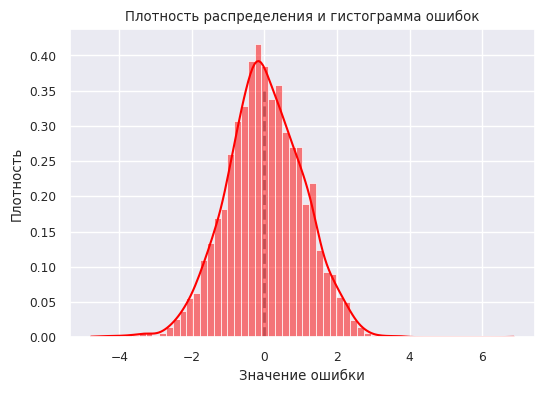

In [19]:
error_distribution(y_test, y_all)

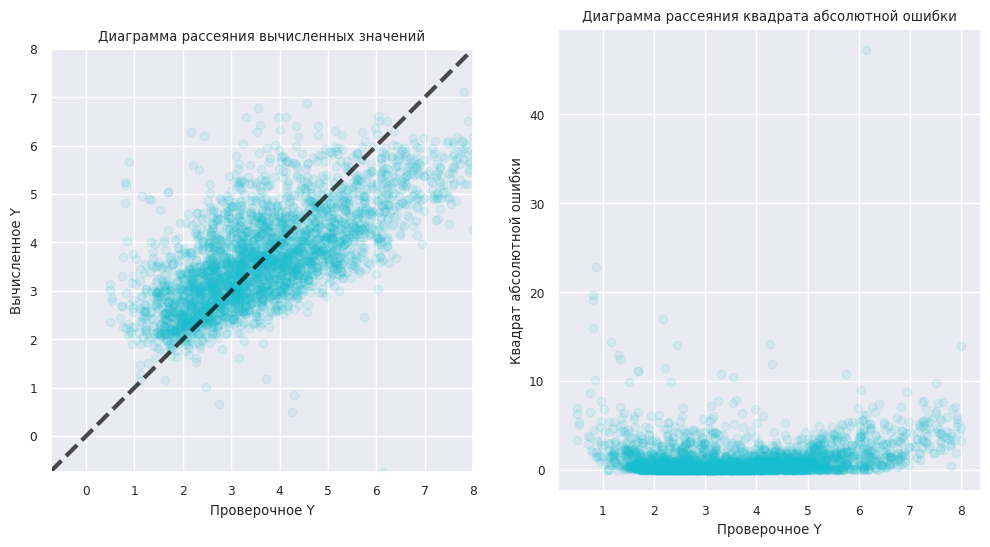

In [20]:
plot_difference(
    y_test = y_test,
    y_pred = y_all
)

In [21]:
stats(
    y_test=y_test,
    y_pred=y_all
)

{'MAE': 0.8402636940985807,
 'MSE': 1.1417494663844314,
 'RMSE': np.float64(1.06852677382667),
 'R2': 0.46136200992895515,
 'Var': np.float64(0.43570639076423806)}

### Бэггинг

In [22]:
print("Признаки:", features)
model_bag = BaggingRegressor()
model_bag.fit(
    x_train,
    y_train
)

Признаки: ['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms', 'Median_Age', 'Population']


,estimator,None
,n_estimators,10
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,None
,verbose,0


In [23]:
y_bag = model_bag.predict(x_test)

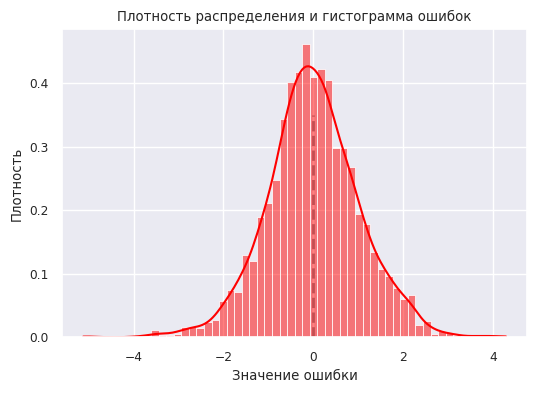

In [24]:
error_distribution(y_test, y_bag)

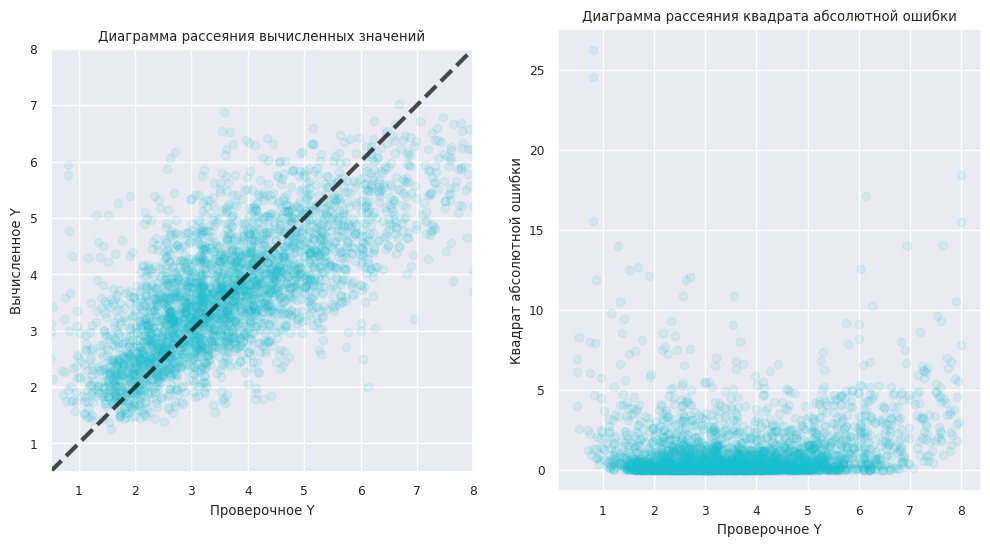

In [25]:
plot_difference(
    y_test = y_test,
    y_pred = y_bag
)

In [26]:
stats(
    y_test=y_test,
    y_pred=y_bag
)

{'MAE': 0.7926527742132599,
 'MSE': 1.0613820287699665,
 'RMSE': np.float64(1.03023396797522),
 'R2': 0.49927659306504224,
 'Var': np.float64(0.433083608301989)}

#### Подбор параметров

In [27]:
n_estimators_list = [10, 50, 100, 200, 500, 1000]
bagging_res = {n:[] for n in n_estimators_list}
for n in n_estimators_list:
    model = BaggingRegressor(n_estimators=n, random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    st = stats(y_test, y_pred)
    bagging_res[n] = st

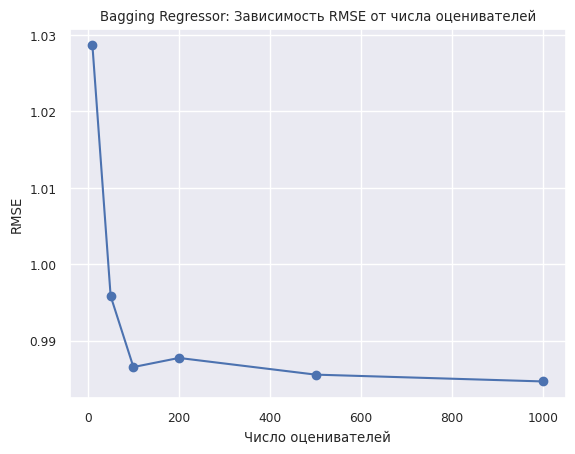

In [31]:
bagging_rmse = [bagging_res[n]['RMSE'] for n in n_estimators_list]
plot_params(
    x_vals=n_estimators_list,
    y_vals=bagging_rmse,
    name='Bagging Regressor: Зависимость RMSE от числа оценивателей',
    xlabel='Число оценивателей',
    ylabel='RMSE'
)

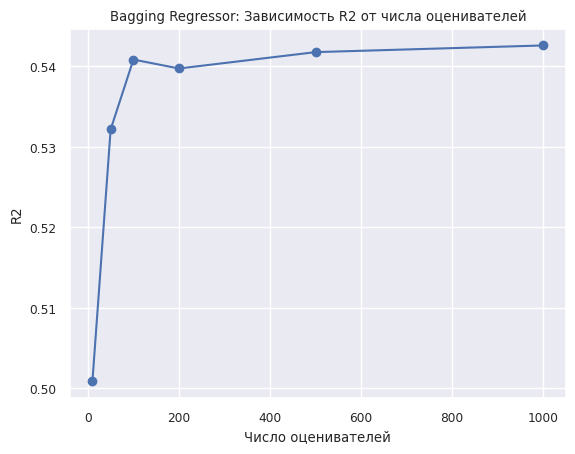

In [32]:
bagging_r2 = [bagging_res[n]['R2'] for n in n_estimators_list]
plot_params(
    x_vals=n_estimators_list,
    y_vals=bagging_r2,
    name='Bagging Regressor: Зависимость R2 от числа оценивателей',
    xlabel='Число оценивателей',
    ylabel='R2'
)

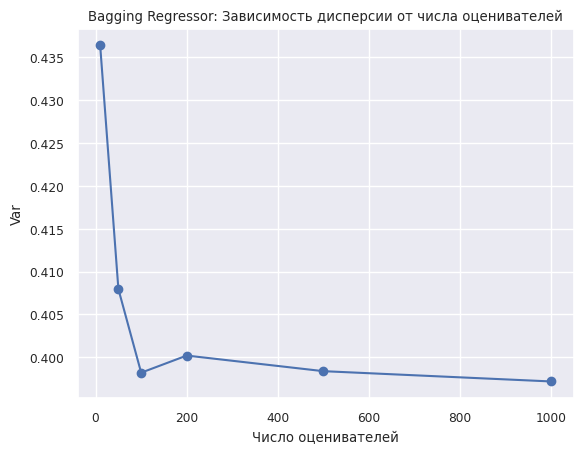

In [33]:
bagging_var = [bagging_res[n]['Var'] for n in n_estimators_list]
plot_params(
    x_vals=n_estimators_list,
    y_vals=bagging_var,
    name='Bagging Regressor: Зависимость дисперсии от числа оценивателей',
    xlabel='Число оценивателей',
    ylabel='Var'
)

### Случайный лес

In [34]:
model_rf = RandomForestRegressor()
model_rf.fit(
    x_train,
    y_train
)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
y_rf = model_rf.predict(x_test)

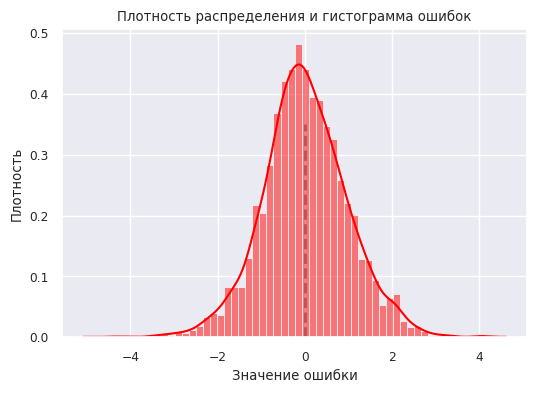

In [36]:
error_distribution(y_test, y_rf)

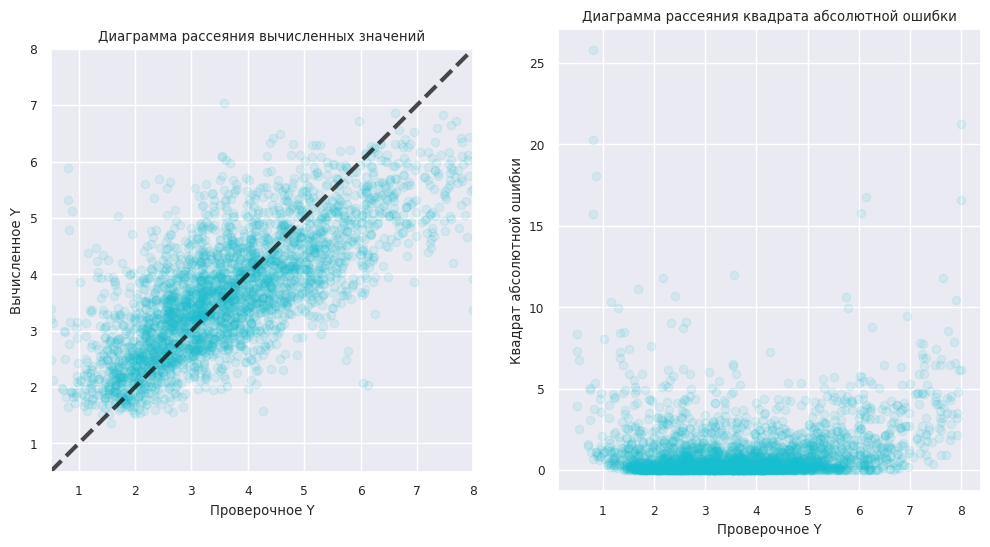

In [37]:
plot_difference(
    y_test = y_test,
    y_pred = y_rf
)

In [38]:
stats(
    y_test=y_test,
    y_pred=y_rf
)

{'MAE': 0.7561645676749159,
 'MSE': 0.9676546350001766,
 'RMSE': np.float64(0.9836943808928547),
 'R2': 0.5434939423882943,
 'Var': np.float64(0.39586978159318403)}

#### Подбор параметров

In [158]:
max_depth_list = [3, 5, 10, 15, 30]
n_estimators_list_rf = [10, 50, 100, 200]
rf_results = {depth: {} for depth in max_depth_list}
for depth in max_depth_list:
    for n in n_estimators_list_rf:
        model = RandomForestRegressor(max_depth=depth, n_estimators=n, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        st = stats(y_test, y_pred)
        rf_results[depth][n] = st

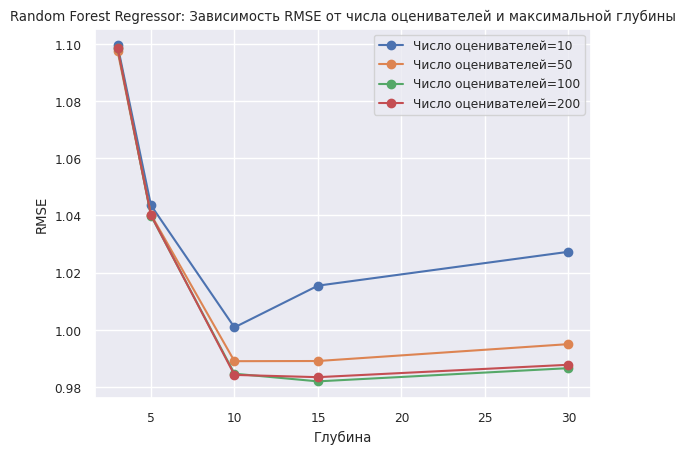

In [159]:
plot_params_multiple_2(
    params1=max_depth_list,
    params2=n_estimators_list_rf,
    results=rf_results,
    target_name='RMSE',
    title='Random Forest Regressor: Зависимость RMSE от числа оценивателей и максимальной глубины',
    xlabel='Глубина',
    ylabel='RMSE',
    param_name='Число оценивателей',
    use_param2=False
)

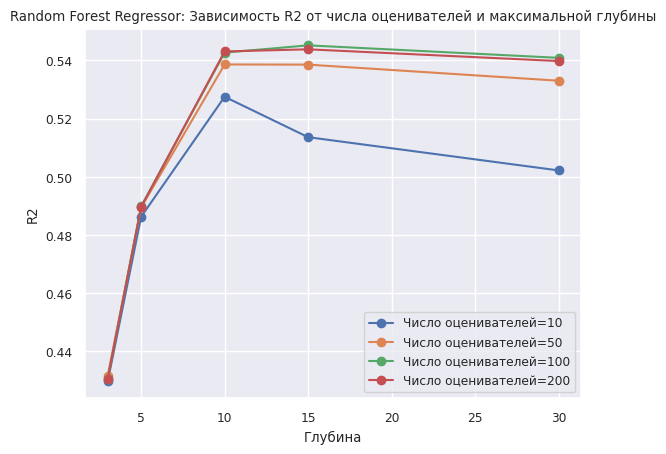

In [160]:
plot_params_multiple_2(
    params1=max_depth_list,
    params2=n_estimators_list_rf,
    results=rf_results,
    target_name='R2',
    title='Random Forest Regressor: Зависимость R2 от числа оценивателей и максимальной глубины',
    xlabel='Глубина',
    ylabel='R2',
    param_name='Число оценивателей',
    use_param2=False
)

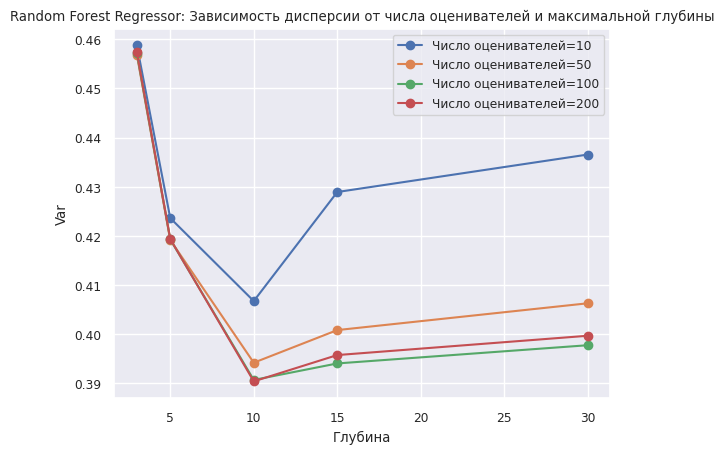

In [161]:
plot_params_multiple_2(
    params1=max_depth_list,
    params2=n_estimators_list_rf,
    results=rf_results,
    target_name='Var',
    title='Random Forest Regressor: Зависимость дисперсии от числа оценивателей и максимальной глубины',
    xlabel='Глубина',
    ylabel='Var',
    param_name='Число оценивателей',
    use_param2=False
)

In [156]:
max_depth_list_2 = [3, 5, 10, 15]
max_features_list = [0.2, 0.4, 0.6, 0.8, 1.0]
n_estimators_2 = 500
rf_results_2 = {max_feat: {} for max_feat in max_features_list}
for max_feat in max_features_list:
    for depth in max_depth_list_2:
        model = RandomForestRegressor(max_depth=depth, max_features=max_feat, n_estimators=n_estimators_2, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        st = stats(y_test, y_pred)
        rf_results_2[max_feat][depth] = st

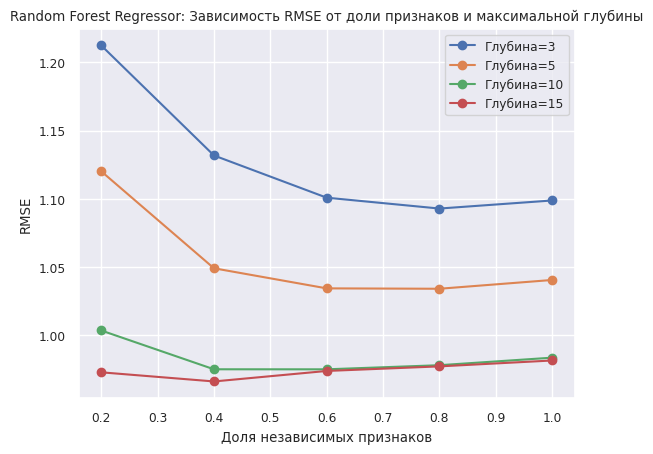

In [157]:
plot_params_multiple_2(
    params1=max_features_list,
    params2=max_depth_list_2,
    results=rf_results_2,
    target_name='RMSE',
    title='Random Forest Regressor: Зависимость RMSE от доли признаков и максимальной глубины',
    xlabel='Доля независимых признаков',
    ylabel='RMSE',
    param_name='Глубина',
    use_param2=False
)

In [165]:
n_estimators_list_3 = [10, 50, 100, 200]
rf_results_3 = {max_feat: {} for max_feat in max_features_list}
for max_feat in max_features_list:
    for n in n_estimators_list_3:
        model = RandomForestRegressor(max_features=max_feat, n_estimators=n, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        st = stats(y_test, y_pred)
        rf_results_3[max_feat][n] = st

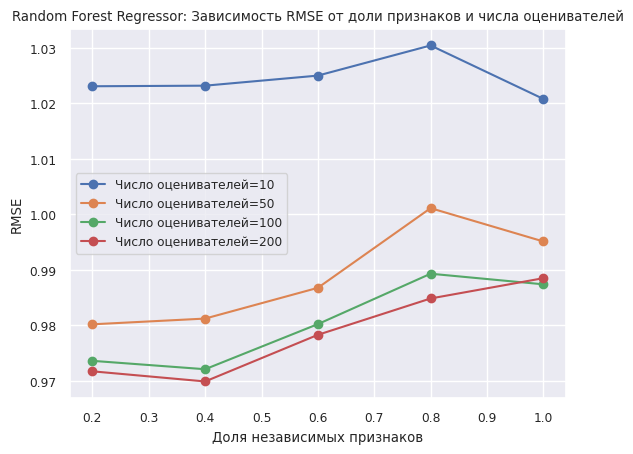

In [166]:
plot_params_multiple_2(
    params1=max_features_list,
    params2=n_estimators_list_3,
    results=rf_results_3,
    target_name='RMSE',
    title='Random Forest Regressor: Зависимость RMSE от доли признаков и числа оценивателей',
    xlabel='Доля независимых признаков',
    ylabel='RMSE',
    param_name='Число оценивателей',
    use_param2=False
)

### Бустинг

In [ ]:
model_gbr = GradientBoostingRegressor()
model_gbr.fit(
    x_train,
    y_train
)

In [ ]:
y_gbr = model_gbr.predict(x_test)

In [ ]:
error_distribution(y_test, y_gbr)

In [ ]:
plot_difference(
    y_test = y_test,
    y_pred = y_gbr
)

In [ ]:
stats(
    y_test=y_test,
    y_pred=y_gbr
)

In [ ]:
# # 4. StackingRegressor: final_estimator
# base_models = [
#     ('ridge', linear_model.Ridge()),
#     ('tree', tree.DecisionTreeRegressor(max_depth=5)),
#     ('svm', svm.SVR())
# ]
# final_models = [linear_model.LinearRegression(), tree.DecisionTreeRegressor(max_depth=5), ensemble.GradientBoostingRegressor(n_estimators=50)]
# st_names = ['Linear', 'Tree', 'GBR']
# stacking_rmse = []
# for meta in final_models:
#     model = StackingRegressor(estimators=base_models, final_estimator=meta, passthrough=False)
#     model.fit(x_train, y_train)
#     y_pred = model.predict(x_test)
#     stacking_rmse.append(stats(y_test, y_pred)['RMSE'])
# results['StackingRegressor'] = (st_names, stacking_rmse)


#### Подбор параметров

In [63]:
learning_rates = [0.001, 0.01, 0.1, 0.3]
n_estimators_list_boosting = [10, 50, 100, 200, 500, 1000]
gbr_results = {lr: {} for lr in learning_rates}
for lr in learning_rates:
    for n in n_estimators_list_boosting:
        model = GradientBoostingRegressor(learning_rate=lr, n_estimators=n, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        st = stats(y_test, y_pred)
        gbr_results[lr][n] = st

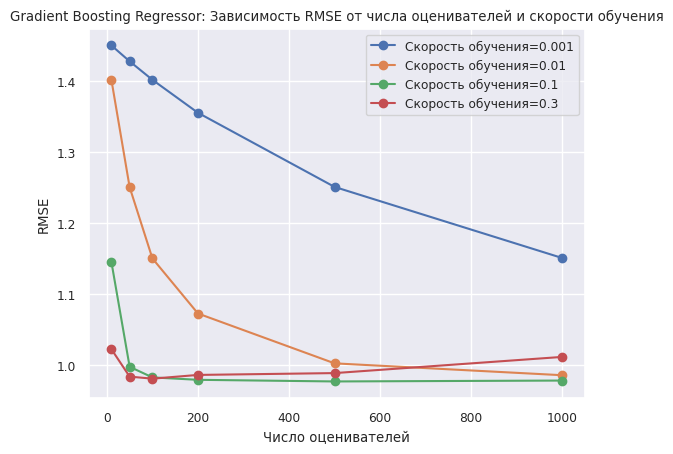

In [66]:
plot_params_multiple_2(
    params1=learning_rates,
    params2=n_estimators_list_boosting,
    results=gbr_results,
    target_name='RMSE',
    title='Gradient Boosting Regressor: Зависимость RMSE от числа оценивателей и скорости обучения',
    xlabel='Число оценивателей',
    ylabel='RMSE',
    param_name='Скорость обучения',
    use_param2=True
)

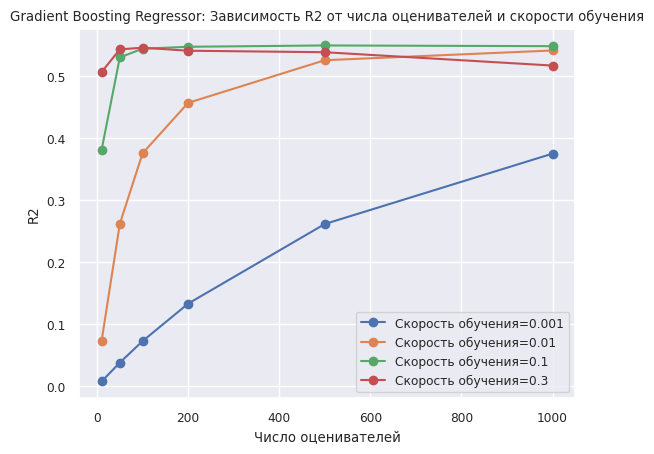

In [67]:
plot_params_multiple_2(
    params1=learning_rates,
    params2=n_estimators_list_boosting,
    results=gbr_results,
    target_name='R2',
    title='Gradient Boosting Regressor: Зависимость R2 от числа оценивателей и скорости обучения',
    xlabel='Число оценивателей',
    ylabel='R2',
    param_name='Скорость обучения',
    use_param2=True
)

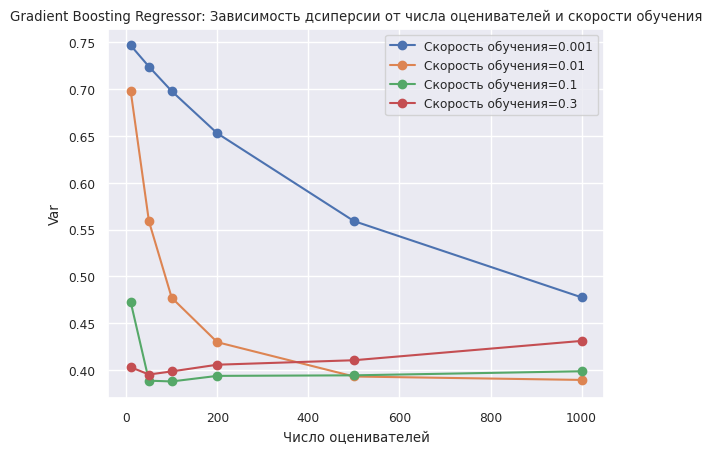

In [68]:
plot_params_multiple_2(
    params1=learning_rates,
    params2=n_estimators_list_boosting,
    results=gbr_results,
    target_name='Var',
    title='Gradient Boosting Regressor: Зависимость дсиперсии от числа оценивателей и скорости обучения',
    xlabel='Число оценивателей',
    ylabel='Var',
    param_name='Скорость обучения',
    use_param2=True
)

In [88]:
learning_rate_fun = [0.001]
n_estimators_list_boosting_fun = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
gbr_results_fun = {lr: {} for lr in learning_rate_fun}
for lr in learning_rate_fun:
    for n in n_estimators_list_boosting_fun:
        model = GradientBoostingRegressor(learning_rate=lr, n_estimators=n, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        st = stats(y_test, y_pred)
        gbr_results_fun[lr][n] = (st)

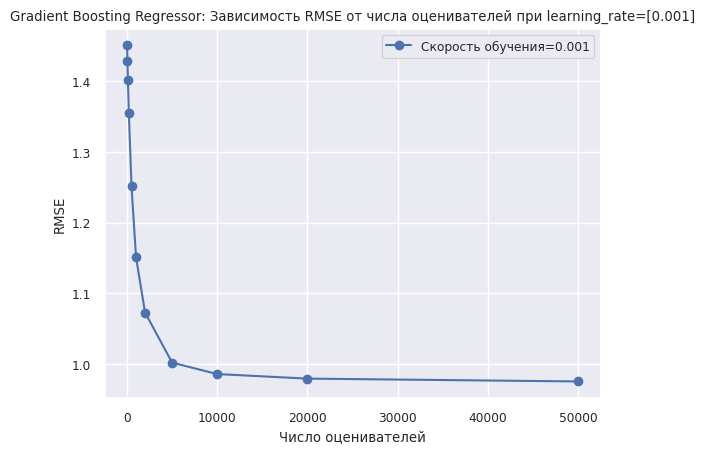

In [89]:
plot_params_multiple_2(
    params1=learning_rate_fun,
    params2=n_estimators_list_boosting_fun,
    results=gbr_results_fun,
    target_name='RMSE',
    title=f'Gradient Boosting Regressor: Зависимость RMSE от числа оценивателей при learning_rate={learning_rate_fun}',
    xlabel='Число оценивателей',
    ylabel='RMSE',
    param_name='Скорость обучения',
    use_param2=True
)

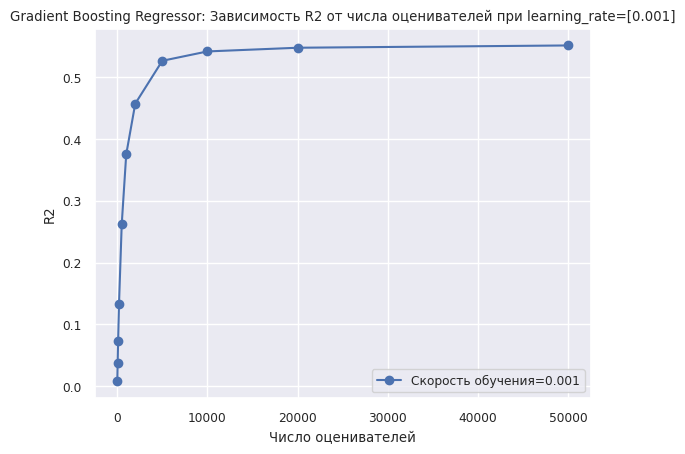

In [90]:
plot_params_multiple_2(
    params1=learning_rate_fun,
    params2=n_estimators_list_boosting_fun,
    results=gbr_results_fun,
    target_name='R2',
    title=f'Gradient Boosting Regressor: Зависимость R2 от числа оценивателей при learning_rate={learning_rate_fun}',
    xlabel='Число оценивателей',
    ylabel='R2',
    param_name='Скорость обучения',
    use_param2=True
)

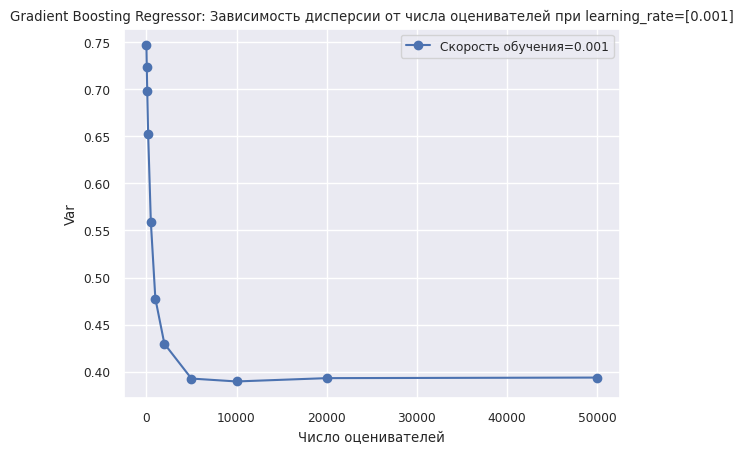

In [91]:
plot_params_multiple_2(
    params1=learning_rate_fun,
    params2=n_estimators_list_boosting_fun,
    results=gbr_results_fun,
    target_name='Var',
    title=f'Gradient Boosting Regressor: Зависимость дисперсии от числа оценивателей при learning_rate={learning_rate_fun}',
    xlabel='Число оценивателей',
    ylabel='Var',
    param_name='Скорость обучения',
    use_param2=True
)

In [134]:
learning_rate_fun2 = 0.01
max_depth_fun2 = [1, 2, 3, 4]
n_estimators_list_boosting_fun2 = [10, 50, 100, 200]
gbr_results_fun2 = {depth: {} for depth in max_depth_fun2}
for depth in max_depth_fun2:
    for n in n_estimators_list_boosting_fun2:
        model = GradientBoostingRegressor(learning_rate=learning_rate_fun2, n_estimators=n, max_depth=depth, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        st = stats(y_test, y_pred)
        gbr_results_fun2[depth][n] = (st)

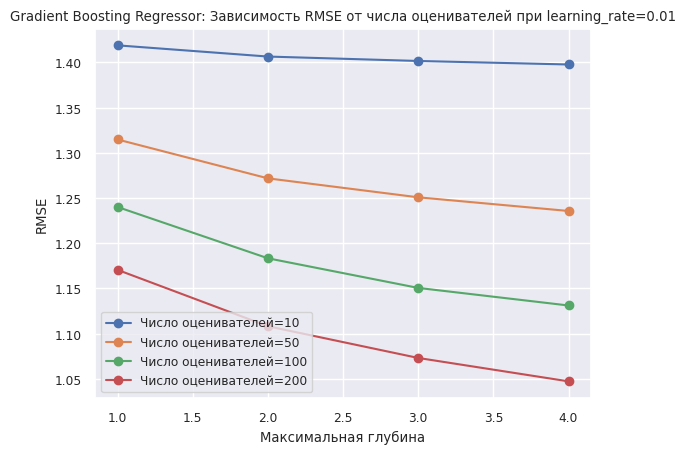

In [145]:
plot_params_multiple_2(
    params1=max_depth_fun2,
    params2=n_estimators_list_boosting_fun2,
    results=gbr_results_fun2,
    target_name='RMSE',
    title=f'Gradient Boosting Regressor: Зависимость RMSE от числа оценивателей при learning_rate={learning_rate_fun2}',
    xlabel='Максимальная глубина',
    ylabel='RMSE',
    param_name='Число оценивателей',
    use_param2=False
)

# Итоги

## Метрики моделей

In [92]:
from IPython.display import display, Markdown

In [120]:
def display_stats(model_description, feature_str, stats):
    mae  = stats["MAE"]
    mse  = stats["MSE"]
    rmse = stats["RMSE"]
    r2   = stats["R2"]
    var  = stats["Var"]
    
    stats_str=f"""
    {model_description}. Признаки: '{feature_str}'.
    MAE : {mae:>9,.3f} (средняя абсолютная ошибка)
    MSE : {mse:>9,.6f} (среднеквадратичная ошибка)
    RMSE: {rmse:>9,.6f} (кв. корень из среднеквадратичной ошибки)
    R2  : {r2:>9,.3f} (коэфф. детерминации)
    Var : {var:>9,.3f} (Дисперсия абсолютной ошибки)
    """
    
    display(Markdown(stats_str))

In [123]:
def display_best(results, param_names, metric, title):
    best_params, best_stats = find_best_config(results, metric=metric, param_names=param_names)
    display_stats(f"{title} лучшее {metric}", features, best_stats)
    print(f"Лучшие параметры (для {metric}):")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    

In [100]:
from typing import Any, Dict, List, Tuple

def flatten_results(nested: Dict[Any, Any], path: List[Tuple[str, Any]] = None) -> List[Tuple[Dict[str, Any], Dict[str, Any]]]:
    """
    Рекурсивно расплющивает вложенный словарь результатов.
    Ожидается, что листовые значения - это словари со статистиками {'RMSE':..., 'R2':...}.
    Возвращает список кортежей: (params_dict, stats_dict).
    
    path - список (param_name, value) для текущего уровня. 
           Если param_name неизвестно, в качестве имени будет использован str(key).
    """
    if path is None:
        path = []
    out = []
    for key, val in nested.items():
        # если на пути ключи - используем их как имена параметров
        # если ключ уже tuple/list (например ('max_depth', 3)), можно адаптировать, но обычно ключи — значения параметров
        current_path = path + [(str(key), key)]
        if isinstance(val, dict):
            # ДАЛЬШЕ: различаем внутренние словари (еще уровни) и листовые — листовые содержат метрики (обычно числовые)
            # Heuristic: считаем листовым, если все значения в val - не словари, или если среди ключей встречаются 'RMSE'/'MAE' и т.д.
            if ('RMSE' in val) or ('MSE' in val) or (not any(isinstance(v, dict) for v in val.values())):
                # лист: val — статистики
                # Собираем параметры из пути: имена param1,param2... — значения key from path
                params = {f'p{i}': p_val for i, (_, p_val) in enumerate(current_path)}
                # БЕЗЫМЯННЫЕ имена p0, p1... — подробнее ниже, можем заменить на читаемые имена
                out.append((params, val))
            else:
                # внутренний словарь: спуск
                out.extend(flatten_results(val, current_path))
        else:
            # Если val не словарь — это странный формат, но обработаем: считаем парой параметр=val и пропускаем
            params = {f'p{i}': p_val for i, (_, p_val) in enumerate(current_path)}
            out.append((params, {'value': val}))
    return out

# Улучшенная flatten-версия, где имена параметров можно передать отдельно:
def flatten_results_with_names(nested: Dict[Any, Any], param_names: List[str]=None) -> List[Tuple[Dict[str, Any], Dict[str, Any]]]:
    """
    Более аккуратная версия: param_names - список имён параметров по уровням вложенности.
    Например, для rf_results: param_names=['max_depth','n_estimators'].
    """
    def _recurse(d, level, acc_params):
        items = []
        for key, val in d.items():
            params = dict(acc_params)  # копия
            name = param_names[level] if (param_names is not None and level < len(param_names)) else f'param_{level}'
            params[name] = key
            if isinstance(val, dict) and not ('RMSE' in val or 'MSE' in val):
                items.extend(_recurse(val, level+1, params))
            else:
                # val — либо stats dict, либо не-словарь
                stats = val if isinstance(val, dict) else {'value': val}
                items.append((params, stats))
        return items
    
    return _recurse(nested, 0, {})

def find_best_config(nested_results: Dict[Any, Any], metric: str = 'RMSE', param_names: List[str] = None):
    """
    Находит конфигурацию с наименьшим значением metric в nested_results.
    param_names - опционально: список имён параметров уровней вложенности (например ['max_depth','n_estimators'])
    Возвращает (best_params_dict, best_stats_dict)
    """
    # используем удобную функцию распаковки
    if param_names is None:
        flat = flatten_results(nested_results)
        # Поменяем имена параметров на более читабельные p0,p1,...
        flat_named = []
        for params, stats in flat:
            # params сейчас {'p0': val0, 'p1': val1, ...}
            flat_named.append((params, stats))
    else:
        flat_named = flatten_results_with_names(nested_results, param_names=param_names)
    
    # фильтруем записи, где нет нужной метрики
    filtered = [(p, s) for (p, s) in flat_named if (isinstance(s, dict) and metric in s)]
    if not filtered:
        raise ValueError(f"Не нашёл ни одной записи с метрикой '{metric}'.")
    
    # выбрать минимальное по metric
    best = min(filtered, key=lambda ps: ps[1].get(metric, float('inf')))
    best_params, best_stats = best
    return best_params, best_stats

In [146]:
bagging_params = ['n_estimators']
display_best(bagging_res, bagging_params, 'RMSE', 'Bagging Regressor')


    Bagging Regressor лучшее RMSE. Признаки: '['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms', 'Median_Age', 'Population']'.
    MAE :     0.757 (средняя абсолютная ошибка)
    MSE :  0.969530 (среднеквадратичная ошибка)
    RMSE:  0.984647 (кв. корень из среднеквадратичной ошибки)
    R2  :     0.543 (коэфф. детерминации)
    Var :     0.397 (Дисперсия абсолютной ошибки)
    

Лучшие параметры (для RMSE):
  n_estimators: 1000


In [170]:
rf_params = ['max_depth', 'n_estimators']
display_best(rf_results, rf_params, 'RMSE', 'Random Forest Regressor')


    Random Forest Regressor лучшее RMSE. Признаки: '['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms', 'Median_Age', 'Population']'.
    MAE :     0.755 (средняя абсолютная ошибка)
    MSE :  0.964048 (среднеквадратичная ошибка)
    RMSE:  0.981860 (кв. корень из среднеквадратичной ошибки)
    R2  :     0.545 (коэфф. детерминации)
    Var :     0.394 (Дисперсия абсолютной ошибки)
    

Лучшие параметры (для RMSE):
  max_depth: 15
  n_estimators: 100


In [168]:
rf_params_2 = ['max_features', 'max_depth']
display_best(rf_results_2, rf_params_2, 'RMSE', 'Random Forest Regressor')


    Random Forest Regressor лучшее RMSE. Признаки: '['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms', 'Median_Age', 'Population']'.
    MAE :     0.745 (средняя абсолютная ошибка)
    MSE :  0.933659 (среднеквадратичная ошибка)
    RMSE:  0.966260 (кв. корень из среднеквадратичной ошибки)
    R2  :     0.560 (коэфф. детерминации)
    Var :     0.378 (Дисперсия абсолютной ошибки)
    

Лучшие параметры (для RMSE):
  max_features: 0.4
  max_depth: 15


In [169]:
rf_params_3 = ['max_features', 'n_estimators']
display_best(rf_results_3, rf_params_3, 'RMSE', 'Random Forest Regressor')


    Random Forest Regressor лучшее RMSE. Признаки: '['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms', 'Median_Age', 'Population']'.
    MAE :     0.746 (средняя абсолютная ошибка)
    MSE :  0.940751 (среднеквадратичная ошибка)
    RMSE:  0.969923 (кв. корень из среднеквадратичной ошибки)
    R2  :     0.556 (коэфф. детерминации)
    Var :     0.385 (Дисперсия абсолютной ошибки)
    

Лучшие параметры (для RMSE):
  max_features: 0.4
  n_estimators: 200


In [149]:
gbr_params = ['learning_rate', 'n_estimators']
display_best(gbr_results, gbr_params, 'RMSE', 'Gradient Boosting Regressor')


    Gradient Boosting Regressor лучшее RMSE. Признаки: '['Median_House_Value', 'Distance_to_coast', 'Tot_Rooms', 'Median_Age', 'Population']'.
    MAE :     0.749 (средняя абсолютная ошибка)
    MSE :  0.955563 (среднеквадратичная ошибка)
    RMSE:  0.977529 (кв. корень из среднеквадратичной ошибки)
    R2  :     0.549 (коэфф. детерминации)
    Var :     0.394 (Дисперсия абсолютной ошибки)
    

Лучшие параметры (для RMSE):
  learning_rate: 0.1
  n_estimators: 500
